In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import classification_report 








%matplotlib inline





In [3]:
train = pd.read_csv("/Users/priyanka/Downloads/instacart_2017_05_01/order_products__train.csv")

In [4]:
prior = pd.read_csv("/Users/priyanka/Downloads/instacart_2017_05_01/order_products__prior.csv")

In [5]:
orders = pd.read_csv("/Users/priyanka/Downloads/orders.csv")



In [6]:
products = pd.read_csv("/Users/priyanka/Downloads/instacart_2017_05_01/products.csv")

In [7]:
aisles = pd.read_csv("/Users/priyanka/Downloads/instacart_2017_05_01/aisles.csv")

In [8]:
departments = pd.read_csv("/Users/priyanka/Downloads/instacart_2017_05_01/departments.csv")

In [9]:
train= train.merge(orders, on='order_id')
prior= prior.merge(orders, on='order_id')

In [10]:
#creating a dataframe for user
user_product= prior.groupby(['product_id','user_id']).order_id.count().to_frame('total_order_products').reset_index()

train_id = train['user_id'].unique() 
df = user_product[user_product['user_id'].isin(train_id)]
df.head()

,product_id,user_id,total_order_products
0,1,138,2
1,1,709,1
3,1,777,1
6,1,1052,2
9,1,1494,3


In [11]:
#User Features
user=pd.DataFrame(prior.groupby(['user_id']).days_since_prior_order.mean())
user.head()
#Average day of week
avg_dow=prior.groupby('user_id').order_dow.mean()
#Average day of hour
avg_doh = prior.groupby('user_id').order_hour_of_day.mean()
user = pd.concat([user,avg_dow,avg_doh],axis=1).reset_index()

In [12]:
total_items=prior.groupby('user_id').order_id.size().to_frame('tot_items').reset_index()
total_orders=prior.groupby(['user_id']).order_id.nunique().to_frame('tot_orders').reset_index()
avg_order_size = pd.merge(total_items,total_orders,on='user_id') 
avg_order_size['avg_order_size'] = avg_order_size['tot_items'] / avg_order_size['tot_orders'] #Average order size for user
user = user.merge(avg_order_size,on='user_id')
user.head()

,user_id,days_since_prior_order,order_dow,order_hour_of_day,tot_items,tot_orders,avg_order_size
0,1,20.259259,2.644068,10.542373,59,10,5.900000
1,2,15.967033,2.005128,10.441026,195,14,13.928571
2,3,11.487179,1.011364,16.352273,88,12,7.333333
3,4,15.357143,4.722222,13.111111,18,5,3.600000
4,5,14.500000,1.621622,15.729730,37,4,9.250000


In [13]:
cart = prior.groupby(['order_id','user_id']).order_id.count().to_frame('cart_item').reset_index().sort_values(by=['user_id'])
reord = prior.loc[prior.reordered==1]
reord_items=reord.groupby(['order_id','user_id','product_id']).order_id.count().to_frame('reord_items').reset_index().sort_values(by=['user_id'])
reorder_items_per_cart = pd.merge(cart,reord_items,on=['order_id','user_id'])
 #Reorder items for cart for an user
reorder_items_per_cart['reord_prob'] =reorder_items_per_cart['reord_items'] / reorder_items_per_cart['cart_item']
reorder_items_per_cart.head()

,order_id,user_id,cart_item,product_id,reord_items,reord_prob
0,473747,1,5,12427,1,0.200
1,473747,1,5,196,1,0.200
2,473747,1,5,10258,1,0.200
3,431534,1,8,10258,1,0.125
4,431534,1,8,25133,1,0.125


In [14]:
#Product Features
prod = prior.groupby(['product_id']).product_id.size().to_frame('total').reset_index() #Total products
prod_reord = prior.loc[prior.reordered==1]
prod_re = prod_reord.groupby('product_id').product_id.size().to_frame('reord_count').reset_index() 
#Product reorder rate
prod['reord_rate'] = prod_re['reord_count'] / prod['total']
prod.head()

,product_id,total,reord_rate
0,1,1852,0.613391
1,2,90,0.133333
2,3,277,0.732852
3,4,329,0.446809
4,5,15,0.600000


In [15]:
#last order item for user
cart_reord = (train.groupby('user_id').agg({'product_id':(lambda x: set(x))}).rename(columns={'product_id':'last_order'}))

df= df.merge(cart_reord, on='user_id')
df['reordered'] = (df.apply(lambda row: row['product_id'] in row['last_order'], axis=1).astype(int))
    
df.head()

,product_id,user_id,total_order_products,last_order,reordered
0,1,138,2,{42475},0
1,907,138,2,{42475},0
2,1000,138,1,{42475},0
3,3265,138,1,{42475},0
4,4913,138,1,{42475},0


In [16]:
#Merging all with the primary dataframe
df = df.merge(user,on='user_id')
df = df.merge(prod,on='product_id')
df = df.merge(products,on='product_id')
df.head()

,product_id,user_id,total_order_products,last_order,reordered,days_since_prior_order,order_dow,order_hour_of_day,tot_items,tot_orders,avg_order_size,total,reord_rate,product_name,aisle_id,department_id
0,1,138,2,{42475},0,10.400000,3.040541,12.689189,148,32,4.625000,1852,0.613391,Chocolate Sandwich Cookies,61,19
1,1,709,1,"{14177, 28577, 37089, 16068, 32005, 45444, 102...",0,7.070968,1.651042,19.333333,192,5,38.400000,1852,0.613391,Chocolate Sandwich Cookies,61,19
2,1,777,1,"{43352, 6184, 16797}",0,12.623853,2.938053,11.716814,113,26,4.346154,1852,0.613391,Chocolate Sandwich Cookies,61,19
3,1,1052,2,{17207},0,10.914894,2.625000,15.145833,48,20,2.400000,1852,0.613391,Chocolate Sandwich Cookies,61,19
4,1,1494,3,{44560},0,6.283582,2.784810,12.215190,158,13,12.153846,1852,0.613391,Chocolate Sandwich Cookies,61,19


In [17]:
#making department id categorical and hot encoding
df['department_id']=df['department_id'].astype(object)
df = pd.get_dummies(df,columns=['department_id'],drop_first=True)

In [132]:
df.head()

,product_id,user_id,total_order_products,last_order,reordered,days_since_prior_order,order_dow,order_hour_of_day,tot_items,tot_orders,...,department_id_12,department_id_13,department_id_14,department_id_15,department_id_16,department_id_17,department_id_18,department_id_19,department_id_20,department_id_21
0,1,138,2,{42475},0,10.400000,3.040541,12.689189,148,32,...,0,0,0,0,0,0,0,1,0,0
1,1,709,1,"{14177, 28577, 37089, 16068, 32005, 45444, 102...",0,7.070968,1.651042,19.333333,192,5,...,0,0,0,0,0,0,0,1,0,0
2,1,777,1,"{43352, 6184, 16797}",0,12.623853,2.938053,11.716814,113,26,...,0,0,0,0,0,0,0,1,0,0
3,1,1052,2,{17207},0,10.914894,2.625000,15.145833,48,20,...,0,0,0,0,0,0,0,1,0,0
4,1,1494,3,{44560},0,6.283582,2.784810,12.215190,158,13,...,0,0,0,0,0,0,0,1,0,0


Text(0.5,1,'Top products reordered')

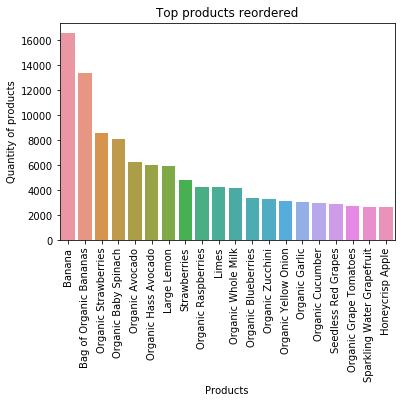

In [64]:
#Top products ordered
pr=df.loc[df.reordered==1]
product_count = pd.DataFrame(pr.product_name.value_counts().head(20).to_frame('count')).reset_index()
sns.barplot(product_count['index'],product_count['count'])
plt.xlabel("Products")
plt.ylabel("Quantity of products")
plt.xticks(rotation=90)
plt.title('Top products reordered')

Text(0.5,1,'Total orders per Hour')

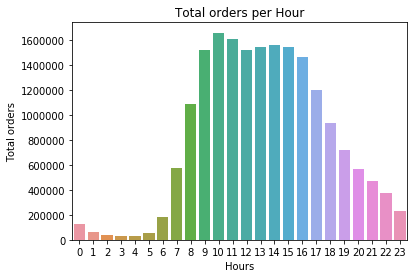

In [65]:
#Peak hours
mo=prior.loc[prior.reordered==1]
g1=pd.DataFrame(mo.order_hour_of_day.value_counts().to_frame('order')).reset_index()
g1=g1.rename(columns={'index':'hours'})
sns.barplot(g1['hours'],g1['order'])
plt.xlabel("Hours")
plt.ylabel("Total orders")
plt.title('Total orders per Hour')
#plt.xticks(rotation=90)

Text(0.5,1,'Total orders for Day')

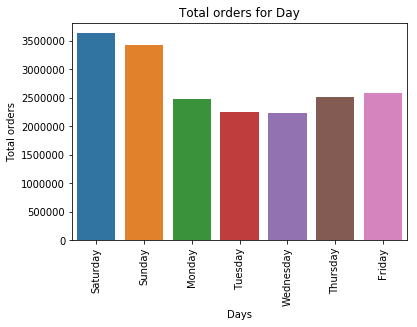

In [66]:
#Peak days
days=prior.loc[prior.reordered==1]
g2=pd.DataFrame(days.order_dow.value_counts().to_frame('order')).reset_index()
g2=g2.rename(columns={'index':'Day'})
sns.barplot(g2['Day'],g2['order'])
plt.xlabel("Days")
plt.ylabel("Total orders")
labels=['Saturday', 'Sunday', 'Friday', 'Thursday', 'Monday','Tuesday','Wednesday']
plt.xticks(g2['Day'],labels,rotation=90)
plt.title('Total orders for Day')

Text(0.5,1,'Add to cart order sequence')

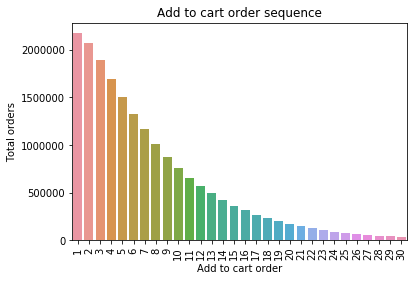

In [67]:
#Cart order sequence is directly proportional to reordered
add = prior.loc[prior.reordered==1]
g4 = pd.DataFrame(add.add_to_cart_order.value_counts().head(30).reset_index())
g4=g4.rename(columns={'index':'add_to_cart_order','add_to_cart_order':'total_orders'})
sns.barplot(g4['add_to_cart_order'],g4['total_orders'])
plt.xlabel('Add to cart order')
plt.ylabel('Total orders')
plt.xticks(rotation = 90)
plt.title('Add to cart order sequence')

In [18]:
#Average cart size for user-product
prod_cart = prior.groupby(['user_id','product_id']).product_id.count().to_frame('prod_cart').reset_index()
total_prod_cart = prior.groupby(['user_id']).order_id.nunique().to_frame('total_prod_cart').reset_index()
avg_cart_size = pd.merge(prod_cart,total_prod_cart,on=['user_id'])
avg_cart_size['avg_cart_order'] = avg_cart_size['prod_cart'] / avg_cart_size['total_prod_cart']
df = df.merge(avg_cart_size,on=['user_id','product_id'])


In [19]:
user_prod_reorder_item = prior.groupby(['user_id','product_id']).reordered.sum().to_frame('user_prod_reord').reset_index()
df2=df.copy() #copy of dataframe
total_order_user = prior.groupby('user_id').user_id.count().to_frame('total_ord_by_user').reset_index()

#Total order of product by user reordered
user_prod_reord = user_prod_reorder_item.merge(total_order_user,on=['user_id'])

#Times the user ordered the product
user_prod_reord['times_reord_by_user'] = user_prod_reord['user_prod_reord'] / user_prod_reord['total_ord_by_user']
df2 = df2.merge(user_prod_reord,on=['user_id','product_id'])

In [27]:
X = df2.drop(['aisle_id','last_order','product_id','total_order_products','user_id','reordered','reord_rate','product_name'],axis=1)

In [28]:
y = df2['reordered']

In [29]:
X.shape

(8474661, 33)

In [30]:
X.columns

Index(['days_since_prior_order', 'order_dow', 'order_hour_of_day', 'tot_items',
       'tot_orders', 'avg_order_size', 'total', 'department_id_2',
       'department_id_3', 'department_id_4', 'department_id_5',
       'department_id_6', 'department_id_7', 'department_id_8',
       'department_id_9', 'department_id_10', 'department_id_11',
       'department_id_12', 'department_id_13', 'department_id_14',
       'department_id_15', 'department_id_16', 'department_id_17',
       'department_id_18', 'department_id_19', 'department_id_20',
       'department_id_21', 'prod_cart', 'total_prod_cart', 'avg_cart_order',
       'user_prod_reord', 'total_ord_by_user', 'times_reord_by_user'],
      dtype='object')

Text(0.5,1,'Class imbalance')

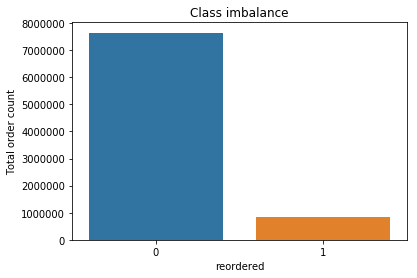

In [96]:
#Class imabalance
sns.countplot(y)
plt.ylabel('Total order count')
plt.title('Class imbalance')

In [140]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
#Scaling the values
scaler=StandardScaler()
X_std=scaler.fit_transform(X_train)
X_std1=scaler.transform(X_test)


In [33]:
#Finding the best parameters
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000,10000000]}
    
clf = GridSearchCV(LogisticRegression(penalty='l2',class_weight={1 : 7, 0 : 1}), param_grid)
clf.fit(X_std,y_train)


/Users/priyanka/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/priyanka/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/priyanka/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/priyanka/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/priyanka/anaconda3/lib/python3.6/site-packages/sklearn

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight={1: 7, 0: 1}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [34]:
print('Best score for data:', clf.score(X_std1,y_test)) 
print('Best C:',clf.estimator.C)

Best score for data: 0.8263132576751329
Best C: 1.0


In [38]:
#Applying class_weight = balanced
lr = LogisticRegression(class_weight='balanced',C=1)
lr.fit(X_std, y_train)
cv_f1 = f1_score(lr.predict(X_std1),y_test)
cv_f1

/Users/priyanka/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.3528035251974365

In [40]:
#Applying class_weight
logreg = LogisticRegression(class_weight={1 : 7, 0 : 1}, C=1)
logreg.fit(X_std, y_train)
cv_f2 = f1_score(logreg.predict(X_std1),y_test)
cv_f2

/Users/priyanka/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.3768604324627914

In [45]:
#Predicted values of y
y_pred = logreg.predict(X_std1)
#Accuracy score
print(metrics.accuracy_score(y_test, y_pred))

0.8263132576751329


In [46]:
#Confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))

[[1967289  326626]
 [ 114955  133529]]


In [47]:
#Assigning TP,FP,TN,FN
confusion = metrics.confusion_matrix(y_test, y_pred)
print(confusion)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[1967289  326626]
 [ 114955  133529]]


In [49]:
#Classification Error
classification_error = (FP + FN) / float(TP + TN + FP + FN)

print(classification_error)
print(1 - metrics.accuracy_score(y_test, y_pred))

0.1736867423248672
0.17368674232486714


In [50]:
#sensitivity
sensitivity = TP / float(FN + TP)
print(sensitivity)
print(metrics.recall_score(y_test, y_pred))

0.5373746398158433
0.5373746398158433


In [51]:
#specificity
specificity = TN / (TN + FP)
print(specificity)

0.8576119864947045


In [52]:
#prediction probability
y_pred_prob = logreg.predict_proba(X_std1)[:, 1]
y_pred_prob

array([0.1987043 , 0.16595324, 0.80969076, ..., 0.11798496, 0.34733356,
       0.48245685])

In [53]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

In [54]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [58]:
evaluate_threshold(0.3)

Sensitivity: 0.8405933581236619
Specificity: 0.5288304056601922


In [60]:
#With Threshold = 0.4
clf = LogisticRegression(class_weight={1 : 7, 0 : 1}, C=1)
clf.fit(X_std, y_train)
THRESHOLD = 0.4
preds = np.where(clf.predict_proba(X_std1)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds),f1_score(y_test,preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score","f1_score"])

/Users/priyanka/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,0
accuracy,0.738829
recall,0.677742
precision,0.223848
roc_auc_score,0.711594
f1_score,0.336541


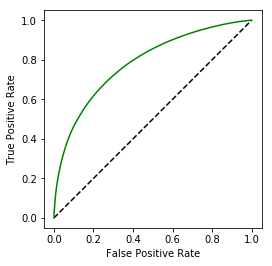

In [63]:
y_score = logreg.predict_proba(X_std1)[:,1]

fpr, tpr,_ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1], linestyle='--', color = 'black')
plt.plot(fpr, tpr, color = 'green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.gca().set_aspect('equal', adjustable='box')

In [123]:
#Applying Decision Tree Algorithm
clf_gini = DecisionTreeClassifier(criterion='gini',class_weight={1 : 7, 0 : 1}, max_depth=5,min_samples_leaf=5,
                                  random_state=90) 
  
# Performing training 
clf_gini.fit(X_std, y_train) 



DecisionTreeClassifier(class_weight={1: 7, 0: 1}, criterion='gini',
            max_depth=5, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=90,
            splitter='best')

In [124]:
y_pred = clf_gini.predict(X_std1)

In [125]:
# how did our model perform?
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))

Misclassified samples: 501478
Accuracy: 0.80


In [126]:
print("Confusion Matrix: ",confusion_matrix(y_test, y_pred)) 
print ("Accuracy : ", accuracy_score(y_test,y_pred)*100) 
print("Report : ", classification_report(y_test, y_pred)) 

Confusion Matrix:  [[1895815  398100]
 [ 103378  145106]]
Accuracy :  80.27540130404394
Report :                precision    recall  f1-score   support

           0       0.95      0.83      0.88   2293915
           1       0.27      0.58      0.37    248484

   micro avg       0.80      0.80      0.80   2542399
   macro avg       0.61      0.71      0.62   2542399
weighted avg       0.88      0.80      0.83   2542399



In [133]:
clf_dtree = DecisionTreeClassifier(criterion='gini',class_weight={1 : 7, 0 : 1}, max_depth=10, min_samples_leaf=5, random_state=75)
clf_dtree.fit(X_std, y_train)
THRESHOLD = 0.4
preds = np.where(clf_dtree.predict_proba(X_std1)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds),f1_score(y_test,preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score","f1_score"])

,0
accuracy,0.701692
recall,0.728212
precision,0.207551
roc_auc_score,0.713516
f1_score,0.323032
